<a href="https://colab.research.google.com/github/Dream-Nine/MachineLearning/blob/master/Inception_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn # All neural network modules, nn.Linear, nn.ReLU, nn.Conv2d, BatchNorm, Loss functions
import torch.backends.cudnn as cudnn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
NUM_CLASSES = 10

In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super(conv_block, self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super(Inception_block, self).__init__()

    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)
    self.branch2 = nn.Sequential(
        conv_block(in_channels, red_3x3, kernel_size=1),
        conv_block(red_3x3, out_3x3, kernel_size=3, stride=1, padding=1)
    )
    self.branch3 = nn.Sequential(
        conv_block(in_channels, red_5x5, kernel_size=1),
        conv_block(red_5x5, out_5x5, kernel_size=5, stride=1, padding=2)
    )
    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        conv_block(in_channels, out_1x1pool, kernel_size=1, stride=1)
    )

  def forward(self, x):
    #               N(batch size) x #filters x H x W  
    # Respectively, dim is 0th,     1st,      2nd, 3rd =>  dim=1은 filter-wise로 concatenate하라는 것을 의미한다.
    return torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], dim=1)
     
class GoogLeNet(nn.Module):
  def __init__(self, in_channels=3, num_classes=NUM_CLASSES):
    super(GoogLeNet, self).__init__()

    self.conv1 = conv_block(in_channels=in_channels, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # In this ordelr : In_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    self.inception3a = Inception_block(192, 64, 96,128, 16, 32, 32)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)
    # If we use input images which size is 32 * 32, then we need not use avg pool
    self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
    self.dropout = nn.Dropout(p=0.4)
    self.fc1 = nn.Linear(1024, num_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.maxpool2(x)

    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)

    x = self.inception4a(x)
    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)
    x = self.inception4e(x)
    x = self.maxpool4(x)

    x = self.inception5a(x)
    x = self.inception5b(x)
    x = x.reshape(x.shape[0], -1) # N x 1 x 1을 N x 1로 reshape
    x = self.dropout(x)
    x = self.fc1(x)

    return x
# How to check the size of output tensor(i.e., whether the network works wll or not)
if __name__ == '__main__':
  x = torch.randn(3, 3, 32, 32)
  model = GoogLeNet()
  print(model(x).shape)

torch.Size([3, 10])


In [ ]:
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
history = dict()
history['train_loss'] = list()
history['test_loss'] = list()
history['test_acc'] = list()

In [ ]:
device = 'cuda'

net = GoogLeNet()
net = net.to(device)
net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.1

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)


def train(epoch):
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        benign_outputs = net(inputs)
        loss = criterion(benign_outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = benign_outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        if batch_idx % 100 == 0:
            print('\nCurrent batch:', str(batch_idx))
            print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
            print('Current benign train loss:', loss.item())
    
    total_train_acc =  round(correct / total, 3)

    print('\nTotal benign train accuarcy:', total_train_acc)
    print('Total benign train loss:', train_loss)
    return train_loss


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += criterion(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()

    test_loss = loss / total
    test_acc = 100. * correct / total
    print('\nTest accuarcy:', test_acc)
    print('Test average loss:', test_loss)

    return test_loss, test_acc


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [ ]:
for epoch in range(1, 201):
    adjust_learning_rate(optimizer, epoch)
    history['train_loss'].append(train(epoch))
    test_loss, test_acc = test(epoch)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)


[ Train epoch: 1 ]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.

Total benign train accuarcy: 0.558
Total benign train loss: 486.8296448588371

[ Test epoch: 8 ]

Test accuarcy: 56.31
Test average loss: 0.012506600123643874

[ Train epoch: 9 ]

Current batch: 0
Current benign train accuracy: 0.625
Current benign train loss: 1.0680410861968994

Current batch: 100
Current benign train accuracy: 0.6171875
Current benign train loss: 1.1802432537078857

Current batch: 200
Current benign train accuracy: 0.5234375
Current benign train loss: 1.3302010297775269

Current batch: 300
Current benign train accuracy: 0.5390625
Current benign train loss: 1.2021068334579468

Total benign train accuarcy: 0.591
Total benign train loss: 456.73240119218826

[ Test epoch: 9 ]

Test accuarcy: 51.7
Test average loss: 0.014727021133899688

[ Train epoch: 10 ]

Current batch: 0
Current benign train accuracy: 0.625
Current benign train loss: 0.9912496209144592

Current batch: 100
Current benign train accuracy: 0.6484375
Current benign trai

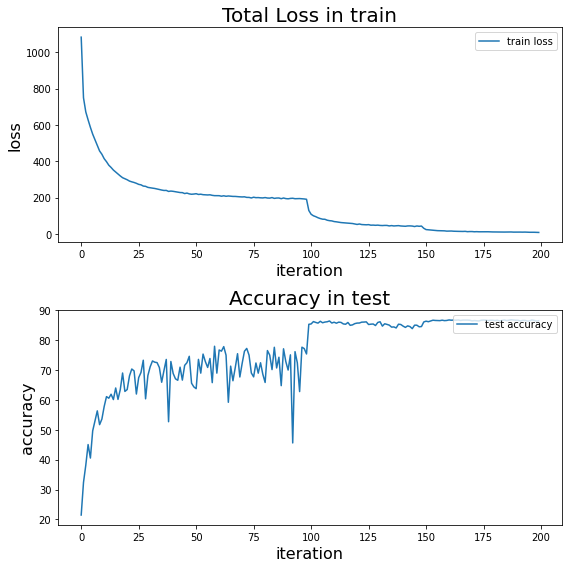

In [ ]:
x = np.arange(200)

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(x, history['train_loss'], label='train loss')
# ax[0].plot(x, history['test_loss'], label='test loss')
ax[1].plot(x, history['test_acc'], label='test accuracy')

for i in range (0,2):
  lines, labels = ax[i].get_legend_handles_labels()
  ax[i].legend(lines, labels, loc = 'upper right')
  ax[i].set_xlabel('iteration', fontsize=16)

ax[0].set_title('Total Loss in train', fontsize=20)
ax[1].set_title('Accuracy in test', fontsize=20)
ax[0].set_ylabel('loss', fontsize=16)
ax[1].set_ylabel('accuracy', fontsize=16)

fig.tight_layout()
plt.show()